In [2]:
from models.base_model import PatchTrADencoder
import yaml 
from types import SimpleNamespace
from omegaconf import OmegaConf
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from copy import deepcopy

# Small JEPATCHTRAD

In [ ]:
config_pre = yaml.load(open("../conf/encoder/config_encoder_small.yaml"), Loader=yaml.FullLoader)
config = SimpleNamespace(**config_pre)

In [ ]:
encoder = PatchTrADencoder(config)
encoder_freeze = deepcopy(encoder)

checkpoint_path = "../checkpoints/ts_jepa_vicreg" + "_" + "1" + ".ckpt"
checkpoint = torch.load(checkpoint_path, weights_only=True)
encoder.load_state_dict(checkpoint)
encoder.eval()
encoder_freeze.eval()

PatchTrADencoder(
  (patcher): Patcher()
  (encoder): TSTiEncoder(
    (W_P): Linear(in_features=5, out_features=128, bias=True)
    (dp): Dropout(p=0.3, inplace=False)
    (encoder): TSTEncoder(
      (layers): ModuleList(
        (0-1): 2 x TSTEncoderLayer(
          (self_attn): _MultiHeadAttention(
            (W_Q): Linear(in_features=128, out_features=128, bias=True)
            (W_K): Linear(in_features=128, out_features=128, bias=True)
            (W_V): Linear(in_features=128, out_features=128, bias=True)
            (sdp): _ScaledDotProduct(
              (attn_dp): Dropout(p=0.0, inplace=False)
            )
            (to_out): Sequential(
              (0): Linear(in_features=128, out_features=128, bias=True)
              (1): Dropout(p=0.3, inplace=False)
            )
          )
          (attn_dp): Dropout(p=0.0, inplace=False)
          (norm_attn): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (ff): Sequential(
            (0): Linear(in_features=

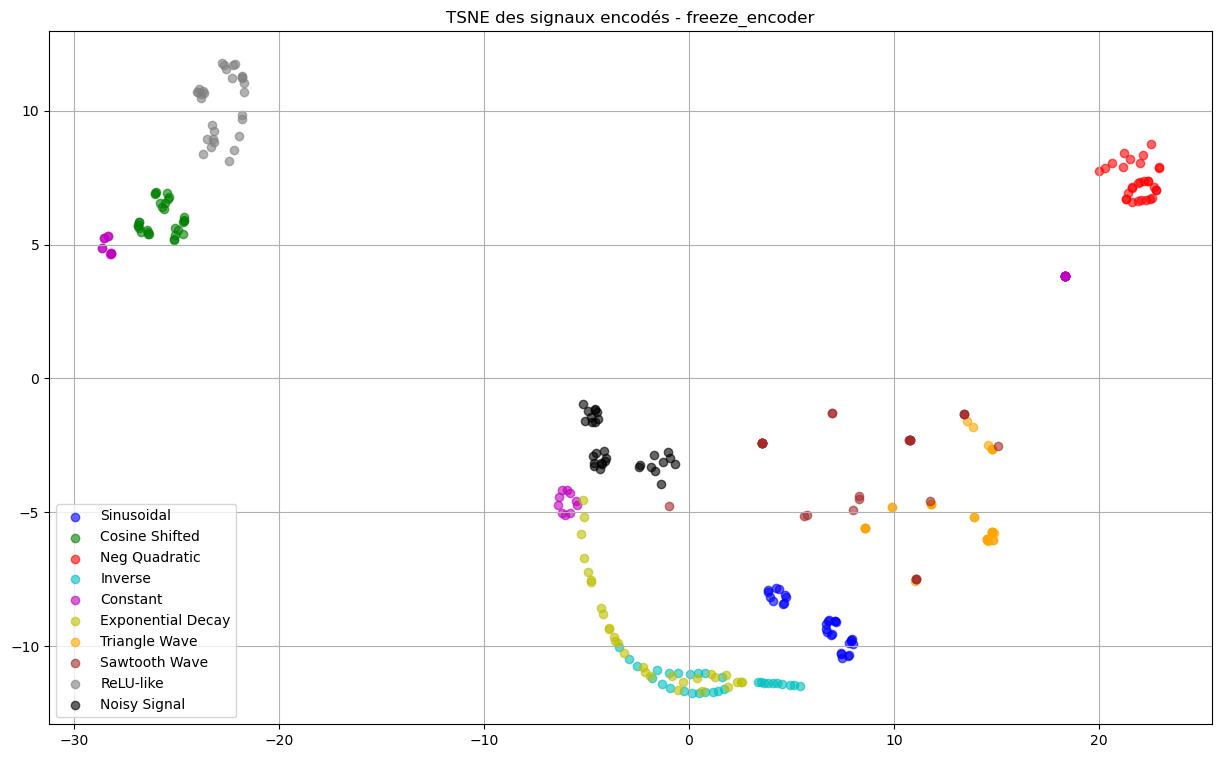

In [ ]:
def generate_and_encode_signal(signal_fn, start_vals):
    ys = []
    for start in start_vals:
        x = torch.linspace(1 * start, 1 * start + 50, 100)
        y = signal_fn(x)
        y = y.unsqueeze(0).unsqueeze(-1)  # Shape: [1, seq_len, 1]
        with torch.no_grad():
            _, encoded = encoder_freeze(y)
        encoded = encoded.squeeze(0).squeeze(0)
        ys.append(encoded)
    return torch.stack(ys, dim=0)

start_vals = [1, 3, 5, 10, 15, 20, 30, 40, 50, 60]

# Définir les variantes pour chaque type de signal
sin_variants = [
    lambda x: torch.sin(x),
    lambda x: torch.sin(x / 2),
    lambda x: torch.sin(x * 2)
]

cos_variants = [
    lambda x: torch.cos(x / 5) + 10,
    lambda x: torch.cos(x / 3) + 5,
    lambda x: 2 * torch.cos(x / 6) + 7
]

quad_variants = [
    lambda x: -x ** 2,
    lambda x: -(x - 25) ** 2,
    lambda x: -0.5 * x ** 2 + 10
]

inv_variants = [
    lambda x: 1 / (x + 1),               # décale pour éviter div par 0
    lambda x: 2 / (x + 1),
    lambda x: -1 / (x + 1)
]

const_variants = [
    lambda x: torch.ones_like(x) * 3,
    lambda x: torch.ones_like(x) * -2,
    lambda x: torch.ones_like(x) * 0.5
]

exp_variants = [
    lambda x: torch.exp(-x / 10),
    lambda x: torch.exp(-x / 20),
    lambda x: 2 * torch.exp(-x / 15)
]

triangle_variants = [
    lambda x: 2 * torch.abs((x % 10) - 5) - 5,
    lambda x: torch.abs((x % 20) - 10) - 5,
    lambda x: 4 * torch.abs(((x / 2) % 5) - 2.5) - 5
]

sawtooth_variants = [
    lambda x: (x % 10) - 5,
    lambda x: ((x % 20) - 10) / 2,
    lambda x: (x % 5) - 2.5
]

relu_like_variants = [
    lambda x: torch.nn.functional.relu(x - 25),
    lambda x: torch.nn.functional.relu(x - 15) * 0.5,
    lambda x: torch.nn.functional.relu(x - 35) * 2
]

noise_variants = [
    lambda x: torch.rand_like(x),                      # bruit uniforme [0, 1]
    lambda x: torch.randn_like(x),                     # bruit gaussien
    lambda x: torch.randn_like(x) * 0.5 + 1.0          # gaussien centré en 1
]


# Générer les embeddings pour chaque type
sin_ys = torch.cat([generate_and_encode_signal(fn, start_vals) for fn in sin_variants], dim=0)
cos_ys = torch.cat([generate_and_encode_signal(fn, start_vals) for fn in cos_variants], dim=0)
quad_ys = torch.cat([generate_and_encode_signal(fn, start_vals) for fn in quad_variants], dim=0)
inv_ys = torch.cat([generate_and_encode_signal(fn, start_vals) for fn in inv_variants], dim=0)
const_ys = torch.cat([generate_and_encode_signal(fn, start_vals) for fn in const_variants], dim=0)
exp_ys = torch.cat([generate_and_encode_signal(fn, start_vals) for fn in exp_variants], dim=0)
triangle_ys = torch.cat([generate_and_encode_signal(fn, start_vals) for fn in triangle_variants], dim=0)
saw_ys = torch.cat([generate_and_encode_signal(fn, start_vals) for fn in sawtooth_variants], dim=0)
relu_ys = torch.cat([generate_and_encode_signal(fn, start_vals) for fn in relu_like_variants], dim=0)
noise_ys = torch.cat([generate_and_encode_signal(fn, start_vals) for fn in noise_variants], dim=0)

# Empiler et aplatir
all_signals = torch.cat([
    sin_ys, cos_ys, quad_ys, inv_ys, const_ys,
    exp_ys, triangle_ys, saw_ys, relu_ys, noise_ys
], dim=0)

all_signals = all_signals.flatten(start_dim=1)

# PCA
pca = TSNE(n_components=2)
all_np = all_signals.cpu().numpy()
embeddings_2d = pca.fit_transform(all_np)

# Affichage
N = len(start_vals)
plt.figure(figsize=(15, 9))
labels = [
    "Sinusoidal",
    "Cosine Shifted",
    "Neg Quadratic",
    "Inverse",
    "Constant",
    "Exponential Decay",
    "Triangle Wave",
    "Sawtooth Wave",
    "ReLU-like",
    "Noisy Signal"
]
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'orange', 'brown', 'gray', 'black']

for i, label in enumerate(labels):
    plt.scatter(
        embeddings_2d[i*N*3:(i+1)*N*3, 0],
        embeddings_2d[i*N*3:(i+1)*N*3, 1],
        alpha=0.6, label=label, color=colors[i % len(colors)]
    )

plt.legend()
plt.title("TSNE des signaux encodés - freeze_encoder")
plt.grid(True)
plt.show()


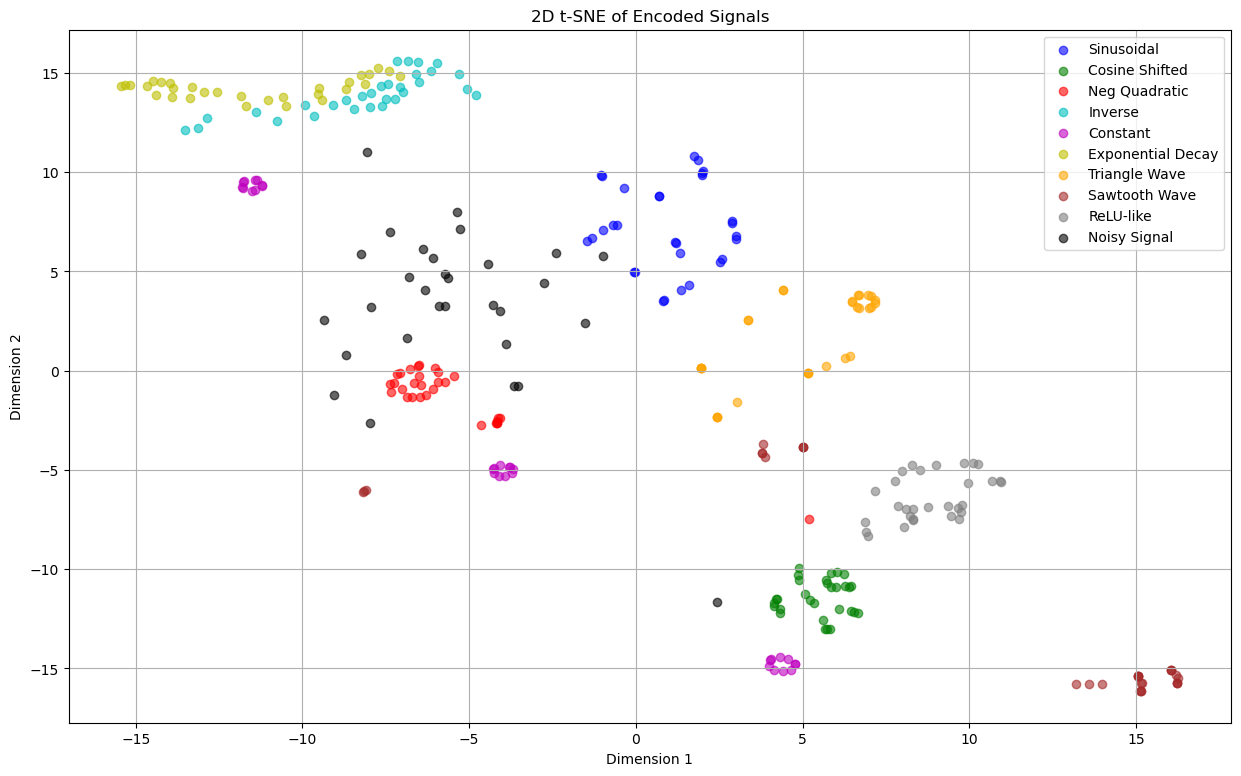

In [ ]:
def generate_and_encode_signal(signal_fn, start_vals):
    ys = []
    for start in start_vals:
        x = torch.linspace(1 * start, 1 * start + 50, 100)
        y = signal_fn(x)
        y = y.unsqueeze(0).unsqueeze(-1)  # Shape: [1, seq_len, 1]
        with torch.no_grad():
            _, encoded = encoder(y)
        encoded = encoded.squeeze(0).squeeze(0)
        ys.append(encoded)
    return torch.stack(ys, dim=0)

start_vals = [1, 3, 5, 10, 15, 20, 30, 40, 50, 60]

# Définir les variantes pour chaque type de signal
sin_variants = [
    lambda x: torch.sin(x),
    lambda x: torch.sin(x / 2),
    lambda x: torch.sin(x * 2)
]

cos_variants = [
    lambda x: torch.cos(x / 5) + 10,
    lambda x: torch.cos(x / 3) + 5,
    lambda x: 2 * torch.cos(x / 6) + 7
]

quad_variants = [
    lambda x: -x ** 2,
    lambda x: -(x - 25) ** 2,
    lambda x: -0.5 * x ** 2 + 10
]

inv_variants = [
    lambda x: 1 / (x + 1),               # décale pour éviter div par 0
    lambda x: 2 / (x + 1),
    lambda x: -1 / (x + 1)
]

const_variants = [
    lambda x: torch.ones_like(x) * 3,
    lambda x: torch.ones_like(x) * -2,
    lambda x: torch.ones_like(x) * 0.5
]

exp_variants = [
    lambda x: torch.exp(-x / 10),
    lambda x: torch.exp(-x / 20),
    lambda x: 2 * torch.exp(-x / 15)
]

triangle_variants = [
    lambda x: 2 * torch.abs((x % 10) - 5) - 5,
    lambda x: torch.abs((x % 20) - 10) - 5,
    lambda x: 4 * torch.abs(((x / 2) % 5) - 2.5) - 5
]

sawtooth_variants = [
    lambda x: (x % 10) - 5,
    lambda x: ((x % 20) - 10) / 2,
    lambda x: (x % 5) - 2.5
]

relu_like_variants = [
    lambda x: torch.nn.functional.relu(x - 25),
    lambda x: torch.nn.functional.relu(x - 15) * 0.5,
    lambda x: torch.nn.functional.relu(x - 35) * 2
]

noise_variants = [
    lambda x: torch.rand_like(x),                      # bruit uniforme [0, 1]
    lambda x: torch.randn_like(x),                     # bruit gaussien
    lambda x: torch.randn_like(x) * 0.5 + 1.0          # gaussien centré en 1
]


# Générer les embeddings pour chaque type
sin_ys = torch.cat([generate_and_encode_signal(fn, start_vals) for fn in sin_variants], dim=0)
cos_ys = torch.cat([generate_and_encode_signal(fn, start_vals) for fn in cos_variants], dim=0)
quad_ys = torch.cat([generate_and_encode_signal(fn, start_vals) for fn in quad_variants], dim=0)
inv_ys = torch.cat([generate_and_encode_signal(fn, start_vals) for fn in inv_variants], dim=0)
const_ys = torch.cat([generate_and_encode_signal(fn, start_vals) for fn in const_variants], dim=0)
exp_ys = torch.cat([generate_and_encode_signal(fn, start_vals) for fn in exp_variants], dim=0)
triangle_ys = torch.cat([generate_and_encode_signal(fn, start_vals) for fn in triangle_variants], dim=0)
saw_ys = torch.cat([generate_and_encode_signal(fn, start_vals) for fn in sawtooth_variants], dim=0)
relu_ys = torch.cat([generate_and_encode_signal(fn, start_vals) for fn in relu_like_variants], dim=0)
noise_ys = torch.cat([generate_and_encode_signal(fn, start_vals) for fn in noise_variants], dim=0)

# Empiler et aplatir
all_signals = torch.cat([
    sin_ys, cos_ys, quad_ys, inv_ys, const_ys,
    exp_ys, triangle_ys, saw_ys, relu_ys, noise_ys
], dim=0)

all_signals = all_signals.flatten(start_dim=1)

# PCA
pca = TSNE(n_components=2)
all_np = all_signals.cpu().numpy()
embeddings_2d = pca.fit_transform(all_np)

# Affichage
N = len(start_vals)
plt.figure(figsize=(15, 9))
labels = [
    "Sinusoidal",
    "Cosine Shifted",
    "Neg Quadratic",
    "Inverse",
    "Constant",
    "Exponential Decay",
    "Triangle Wave",
    "Sawtooth Wave",
    "ReLU-like",
    "Noisy Signal"
]
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'orange', 'brown', 'gray', 'black']

for i, label in enumerate(labels):
    plt.scatter(
        embeddings_2d[i*N*3:(i+1)*N*3, 0],
        embeddings_2d[i*N*3:(i+1)*N*3, 1],
        alpha=0.6, label=label, color=colors[i % len(colors)]
    )

plt.legend()
plt.title("2D t-SNE of Encoded Signals")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")

plt.grid(True)
plt.show()


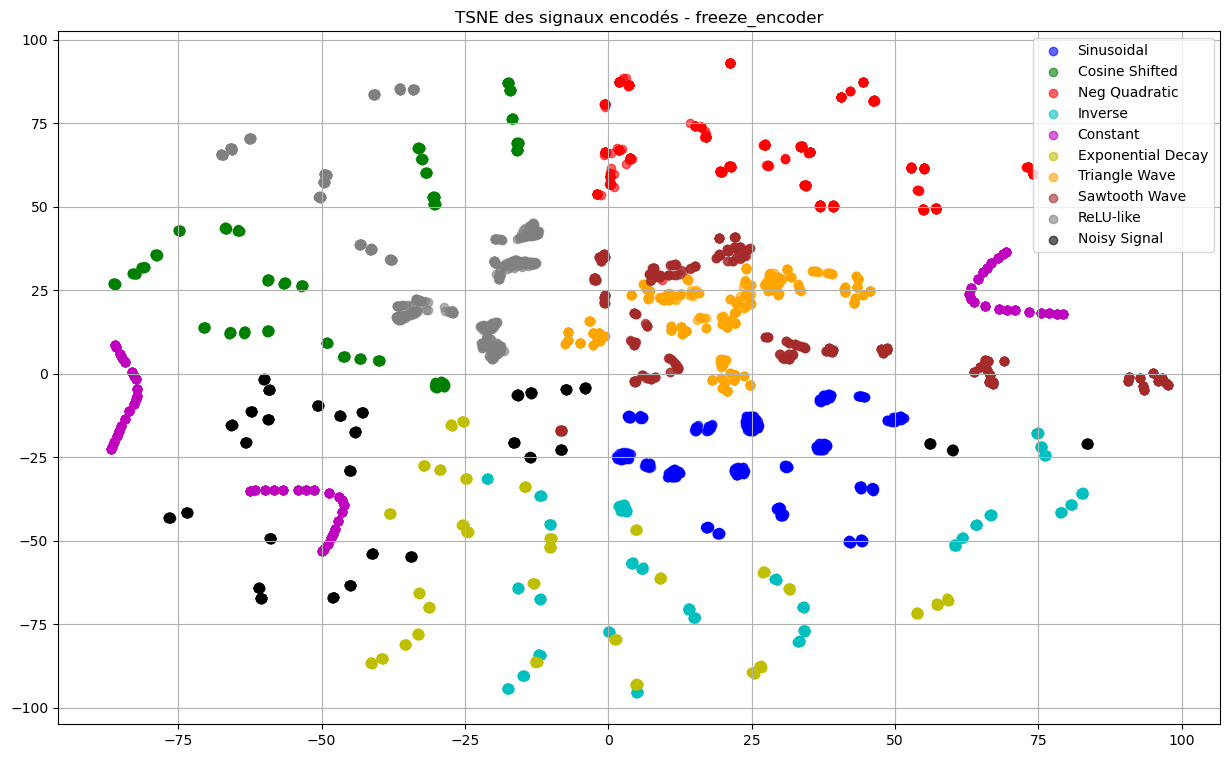

In [ ]:
def generate_and_encode_signal(signal_fn, start_vals):
    ys = []
    for start in start_vals:
        x = torch.linspace(1 * start, 1 * start + 50, 100)
        y = signal_fn(x)
        y = y.unsqueeze(0).unsqueeze(-1)  # Shape: [1, seq_len, 1]
        with torch.no_grad():
            _, encoded = encoder_freeze(y)
        encoded = encoded.squeeze(0).squeeze(0)
        ys.append(encoded)
    return torch.stack(ys, dim=0)

start_vals = [1, 3, 5, 10, 15, 20, 30, 40, 50, 60]

# Définir les variantes pour chaque type de signal
sin_variants = [
    lambda x: torch.sin(x),
    lambda x: torch.sin(x / 2),
    lambda x: torch.sin(x * 2)
]

cos_variants = [
    lambda x: torch.cos(x / 5) + 10,
    lambda x: torch.cos(x / 3) + 5,
    lambda x: 2 * torch.cos(x / 6) + 7
]

quad_variants = [
    lambda x: -x ** 2,
    lambda x: -(x - 25) ** 2,
    lambda x: -0.5 * x ** 2 + 10
]

inv_variants = [
    lambda x: 1 / (x + 1),               # décale pour éviter div par 0
    lambda x: 2 / (x + 1),
    lambda x: -1 / (x + 1)
]

const_variants = [
    lambda x: torch.ones_like(x) * 3,
    lambda x: torch.ones_like(x) * -2,
    lambda x: torch.ones_like(x) * 0.5
]

exp_variants = [
    lambda x: torch.exp(-x / 10),
    lambda x: torch.exp(-x / 20),
    lambda x: 2 * torch.exp(-x / 15)
]

triangle_variants = [
    lambda x: 2 * torch.abs((x % 10) - 5) - 5,
    lambda x: torch.abs((x % 20) - 10) - 5,
    lambda x: 4 * torch.abs(((x / 2) % 5) - 2.5) - 5
]

sawtooth_variants = [
    lambda x: (x % 10) - 5,
    lambda x: ((x % 20) - 10) / 2,
    lambda x: (x % 5) - 2.5
]

relu_like_variants = [
    lambda x: torch.nn.functional.relu(x - 25),
    lambda x: torch.nn.functional.relu(x - 15) * 0.5,
    lambda x: torch.nn.functional.relu(x - 35) * 2
]

noise_variants = [
    lambda x: torch.rand_like(x),                      # bruit uniforme [0, 1]
    lambda x: torch.randn_like(x),                     # bruit gaussien
    lambda x: torch.randn_like(x) * 0.5 + 1.0          # gaussien centré en 1
]


# Générer les embeddings pour chaque type
sin_ys = torch.cat([generate_and_encode_signal(fn, start_vals) for fn in sin_variants], dim=0)
cos_ys = torch.cat([generate_and_encode_signal(fn, start_vals) for fn in cos_variants], dim=0)
quad_ys = torch.cat([generate_and_encode_signal(fn, start_vals) for fn in quad_variants], dim=0)
inv_ys = torch.cat([generate_and_encode_signal(fn, start_vals) for fn in inv_variants], dim=0)
const_ys = torch.cat([generate_and_encode_signal(fn, start_vals) for fn in const_variants], dim=0)
exp_ys = torch.cat([generate_and_encode_signal(fn, start_vals) for fn in exp_variants], dim=0)
triangle_ys = torch.cat([generate_and_encode_signal(fn, start_vals) for fn in triangle_variants], dim=0)
saw_ys = torch.cat([generate_and_encode_signal(fn, start_vals) for fn in sawtooth_variants], dim=0)
relu_ys = torch.cat([generate_and_encode_signal(fn, start_vals) for fn in relu_like_variants], dim=0)
noise_ys = torch.cat([generate_and_encode_signal(fn, start_vals) for fn in noise_variants], dim=0)

# Empiler et aplatir
all_signals = torch.cat([
    sin_ys, cos_ys, quad_ys, inv_ys, const_ys,
    exp_ys, triangle_ys, saw_ys, relu_ys, noise_ys
], dim=0)

all_signals = all_signals.view(all_signals.size(0)*all_signals.size(1), all_signals.size(2))

# PCA
pca = TSNE(n_components=2)
all_np = all_signals.cpu().numpy()
embeddings_2d = pca.fit_transform(all_np)

# Affichage
N = len(start_vals)
plt.figure(figsize=(15, 9))
labels = [
    "Sinusoidal",
    "Cosine Shifted",
    "Neg Quadratic",
    "Inverse",
    "Constant",
    "Exponential Decay",
    "Triangle Wave",
    "Sawtooth Wave",
    "ReLU-like",
    "Noisy Signal"
]
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'orange', 'brown', 'gray', 'black']

for i, label in enumerate(labels):
    plt.scatter(
        embeddings_2d[i*N*3*20:(i+1)*N*3*20, 0],
        embeddings_2d[i*N*3*20:(i+1)*N*3*20, 1],
        alpha=0.6, label=label, color=colors[i % len(colors)]
    )

plt.legend()
plt.title("TSNE des signaux encodés - freeze_encoder")
plt.grid(True)
plt.show()


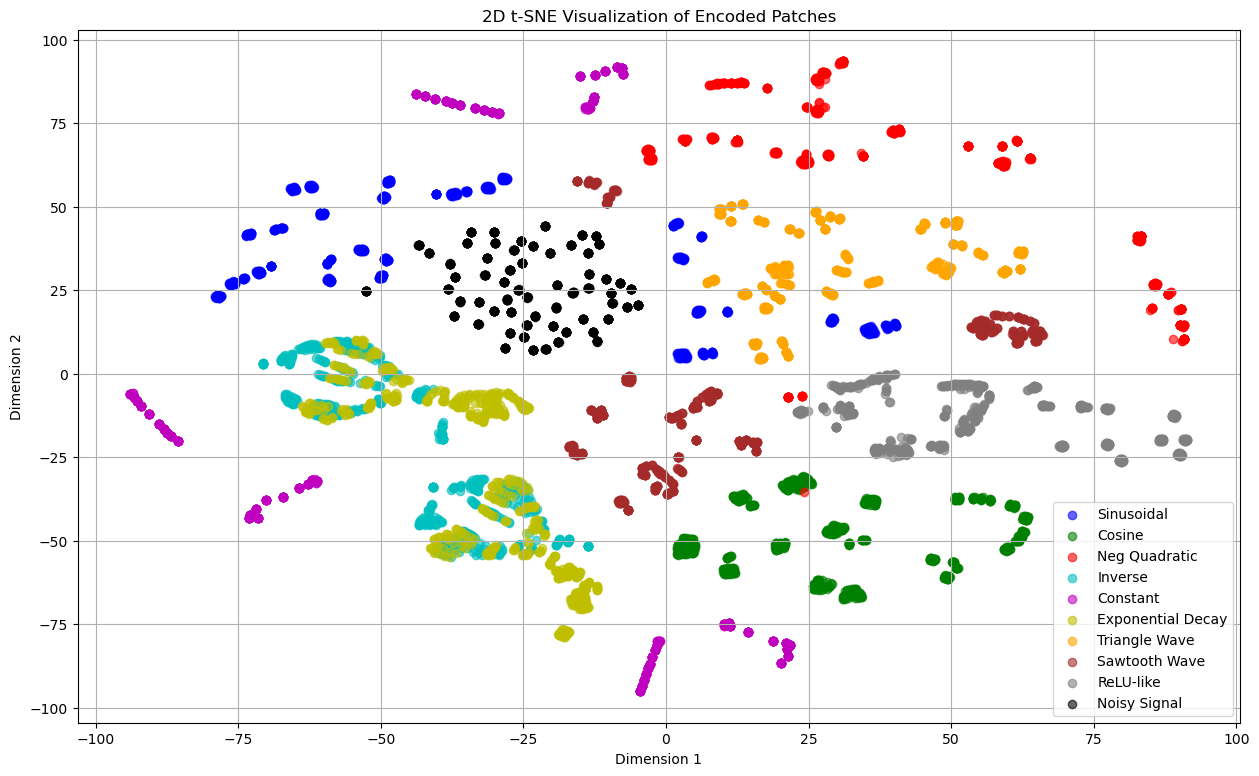

In [ ]:
def generate_and_encode_signal(signal_fn, start_vals):
    ys = []
    for start in start_vals:
        x = torch.linspace(1 * start, 1 * start + 50, 100)
        y = signal_fn(x)
        y = y.unsqueeze(0).unsqueeze(-1)  # Shape: [1, seq_len, 1]
        with torch.no_grad():
            _, encoded = encoder(y)
        encoded = encoded.squeeze(0).squeeze(0)
        ys.append(encoded)
    return torch.stack(ys, dim=0)

start_vals = [1, 3, 5, 10, 15, 20, 30, 40, 50, 60]

# Définir les variantes pour chaque type de signal
sin_variants = [
    lambda x: torch.sin(x),
    lambda x: torch.sin(x / 2),
    lambda x: torch.sin(x * 2)
]

cos_variants = [
    lambda x: torch.cos(x / 5) + 10,
    lambda x: torch.cos(x / 3) + 5,
    lambda x: 2 * torch.cos(x / 6) + 7
]

quad_variants = [
    lambda x: -x ** 2,
    lambda x: -(x - 25) ** 2,
    lambda x: -0.5 * x ** 2 + 10
]

inv_variants = [
    lambda x: 1 / (x + 1),               # décale pour éviter div par 0
    lambda x: 2 / (x + 1),
    lambda x: -1 / (x + 1)
]

const_variants = [
    lambda x: torch.ones_like(x) * 3,
    lambda x: torch.ones_like(x) * -2,
    lambda x: torch.ones_like(x) * 0.5
]

exp_variants = [
    lambda x: torch.exp(-x / 10),
    lambda x: torch.exp(-x / 20),
    lambda x: 2 * torch.exp(-x / 15)
]

triangle_variants = [
    lambda x: 2 * torch.abs((x % 10) - 5) - 5,
    lambda x: torch.abs((x % 20) - 10) - 5,
    lambda x: 4 * torch.abs(((x / 2) % 5) - 2.5) - 5
]

sawtooth_variants = [
    lambda x: (x % 10) - 5,
    lambda x: ((x % 20) - 10) / 2,
    lambda x: (x % 5) - 2.5
]

relu_like_variants = [
    lambda x: torch.nn.functional.relu(x - 25),
    lambda x: torch.nn.functional.relu(x - 15) * 0.5,
    lambda x: torch.nn.functional.relu(x - 35) * 2
]

noise_variants = [
    lambda x: torch.rand_like(x),                      # bruit uniforme [0, 1]
    lambda x: torch.randn_like(x),                     # bruit gaussien
    lambda x: torch.randn_like(x) * 0.5 + 1.0          # gaussien centré en 1
]


# Générer les embeddings pour chaque type
sin_ys = torch.cat([generate_and_encode_signal(fn, start_vals) for fn in sin_variants], dim=0)
cos_ys = torch.cat([generate_and_encode_signal(fn, start_vals) for fn in cos_variants], dim=0)
quad_ys = torch.cat([generate_and_encode_signal(fn, start_vals) for fn in quad_variants], dim=0)
inv_ys = torch.cat([generate_and_encode_signal(fn, start_vals) for fn in inv_variants], dim=0)
const_ys = torch.cat([generate_and_encode_signal(fn, start_vals) for fn in const_variants], dim=0)
exp_ys = torch.cat([generate_and_encode_signal(fn, start_vals) for fn in exp_variants], dim=0)
triangle_ys = torch.cat([generate_and_encode_signal(fn, start_vals) for fn in triangle_variants], dim=0)
saw_ys = torch.cat([generate_and_encode_signal(fn, start_vals) for fn in sawtooth_variants], dim=0)
relu_ys = torch.cat([generate_and_encode_signal(fn, start_vals) for fn in relu_like_variants], dim=0)
noise_ys = torch.cat([generate_and_encode_signal(fn, start_vals) for fn in noise_variants], dim=0)

# Empiler et aplatir
all_signals = torch.cat([
    sin_ys, cos_ys, quad_ys, inv_ys, const_ys,
    exp_ys, triangle_ys, saw_ys, relu_ys, noise_ys
], dim=0)

all_signals = all_signals.view(all_signals.size(0)*all_signals.size(1), all_signals.size(2))

# PCA
pca = TSNE(n_components=2)
all_np = all_signals.cpu().numpy()
embeddings_2d = pca.fit_transform(all_np)

# Affichage
N = len(start_vals)
plt.figure(figsize=(15, 9))
labels = [
    "Sinusoidal",
    "Cosine",
    "Neg Quadratic",
    "Inverse",
    "Constant",
    "Exponential Decay",
    "Triangle Wave",
    "Sawtooth Wave",
    "ReLU-like",
    "Noisy Signal"
]
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'orange', 'brown', 'gray', 'black']

for i, label in enumerate(labels):
    plt.scatter(
        embeddings_2d[i*N*3*20:(i+1)*N*3*20, 0],
        embeddings_2d[i*N*3*20:(i+1)*N*3*20, 1],
        alpha=0.6, label=label, color=colors[i % len(colors)]
    )

plt.legend()
plt.title("2D t-SNE Visualization of Encoded Patches")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.savefig("tsne_plot.png")
plt.show()

In [ ]:
x = torch.linspace(1, 10, 100)
y1 = torch.sin(x).unsqueeze(0).unsqueeze(-1)
y2 = torch.exp(-x).unsqueeze(0).unsqueeze(-1)

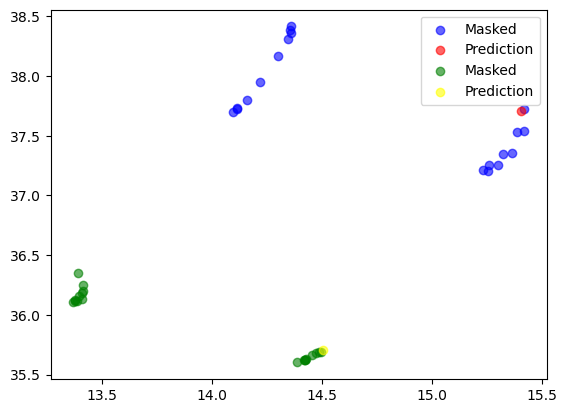

In [ ]:
mask = torch.tensor([[i for i in range(19)]])

encoder.eval()
encoder_freeze.eval()

with torch.no_grad():
    _, h_mask1 = encoder(y1, mask)
    _, h_tar1 = encoder(y1)
    _, h_mask2 = encoder(y2, mask)
    _, h_tar2 = encoder(y2)

embeddings_inp1 = h_mask1.squeeze(0).squeeze(0)
embeddings_pred1 = h_tar1.squeeze(0).squeeze(0)[19, :].unsqueeze(0)

embeddings_inp2 = h_mask2.squeeze(0).squeeze(0)
embeddings_pred2 = h_tar2.squeeze(0).squeeze(0)[19, :].unsqueeze(0)

concat = torch.cat((embeddings_inp1, embeddings_pred1, embeddings_inp2, embeddings_pred2), dim=0)

pca = TSNE(n_components=2)
all_np = concat.cpu().numpy()
embeddings_2d = pca.fit_transform(all_np)

plt.scatter(
    embeddings_2d[0:19, 0],
    embeddings_2d[0:19, 1],
    alpha=0.6, label="Masked", color='blue'
)
plt.scatter(
    embeddings_2d[19, 0],
    embeddings_2d[19, 1],
    alpha=0.6, label="Prediction", color='red'
)
plt.scatter(
    embeddings_2d[20:39, 0],
    embeddings_2d[20:39, 1],
    alpha=0.6, label="Masked", color='green'
)
plt.scatter(
    embeddings_2d[39, 0],
    embeddings_2d[39, 1],
    alpha=0.6, label="Prediction", color='yellow'
)
plt.legend()

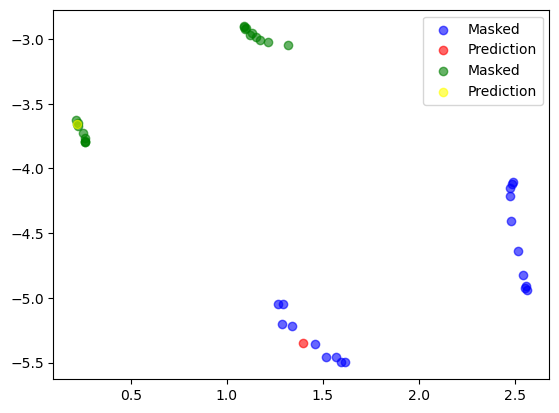

In [ ]:
encoder.eval()
encoder_freeze.eval()

mask = torch.tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19]]) # 11 is missing
mask_index = 11

with torch.no_grad():
    _, h_mask1 = encoder(y1, mask)
    _, h_tar1 = encoder(y1)
    _, h_mask2 = encoder(y2, mask)
    _, h_tar2 = encoder(y2)

embeddings_inp1 = h_mask1.squeeze(0).squeeze(0)
embeddings_pred1 = h_tar1.squeeze(0).squeeze(0)[mask_index, :].unsqueeze(0)

embeddings_inp2 = h_mask2.squeeze(0).squeeze(0)
embeddings_pred2 = h_tar2.squeeze(0).squeeze(0)[mask_index, :].unsqueeze(0)

concat = torch.cat((embeddings_inp1, embeddings_pred1, embeddings_inp2, embeddings_pred2), dim=0)

pca = TSNE(n_components=2)
all_np = concat.cpu().numpy()
embeddings_2d = pca.fit_transform(all_np)

plt.scatter(
    embeddings_2d[mask.flatten(), 0],
    embeddings_2d[mask.flatten(), 1],
    alpha=0.6, label="Masked", color='blue'
)
plt.scatter(
    embeddings_2d[mask_index, 0],
    embeddings_2d[mask_index, 1],
    alpha=0.6, label="Prediction", color='red'
)

plt.scatter(
    embeddings_2d[mask.flatten() + 20, 0],
    embeddings_2d[mask.flatten() + 20, 1],
    alpha=0.6, label="Masked", color='green'
)
plt.scatter(
    embeddings_2d[mask_index +20, 0],
    embeddings_2d[mask_index +20, 1],
    alpha=0.6, label="Prediction", color='yellow'
)

plt.legend()

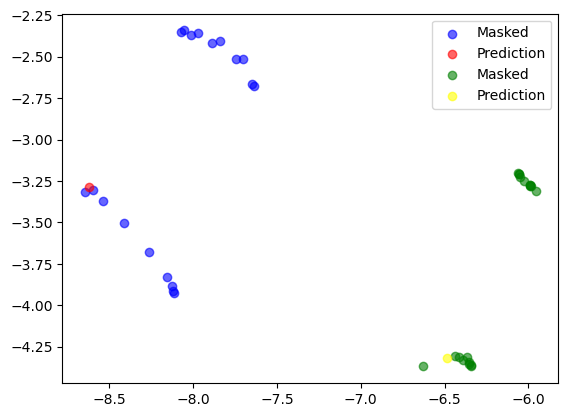

In [ ]:
encoder.eval()
encoder_freeze.eval()

mask = torch.tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]]) 
mask_index = 0

with torch.no_grad():
    _, h_mask1 = encoder(y1, mask)
    _, h_tar1 = encoder(y1)
    _, h_mask2 = encoder(y2, mask)
    _, h_tar2 = encoder(y2)

embeddings_inp1 = h_mask1.squeeze(0).squeeze(0)
embeddings_pred1 = h_tar1.squeeze(0).squeeze(0)[mask_index, :].unsqueeze(0)

embeddings_inp2 = h_mask2.squeeze(0).squeeze(0)
embeddings_pred2 = h_tar2.squeeze(0).squeeze(0)[mask_index, :].unsqueeze(0)

concat = torch.cat((embeddings_inp1, embeddings_pred1, embeddings_inp2, embeddings_pred2), dim=0)

pca = TSNE(n_components=2)
all_np = concat.cpu().numpy()
embeddings_2d = pca.fit_transform(all_np)

plt.scatter(
    embeddings_2d[mask.flatten(), 0],
    embeddings_2d[mask.flatten(), 1],
    alpha=0.6, label="Masked", color='blue'
)
plt.scatter(
    embeddings_2d[mask_index, 0],
    embeddings_2d[mask_index, 1],
    alpha=0.6, label="Prediction", color='red'
)

plt.scatter(
    embeddings_2d[mask.flatten() + 20, 0],
    embeddings_2d[mask.flatten() + 20, 1],
    alpha=0.6, label="Masked", color='green'
)
plt.scatter(
    embeddings_2d[mask_index +20, 0],
    embeddings_2d[mask_index +20, 1],
    alpha=0.6, label="Prediction", color='yellow'
)

plt.legend()

# Big JEPATCHTRAD

In [ ]:
config_pre = yaml.load(open("../conf/encoder/config_encoder_big.yaml"), Loader=yaml.FullLoader)
config = SimpleNamespace(**config_pre)

In [ ]:
encoder = PatchTrADencoder(config)
encoder_freeze = deepcopy(encoder)

checkpoint_path = "../checkpoints/ts_jepa_vicreg_big" + "_" + "1" + ".ckpt"
checkpoint = torch.load(checkpoint_path, weights_only=True)
encoder.load_state_dict(checkpoint)

<All keys matched successfully>

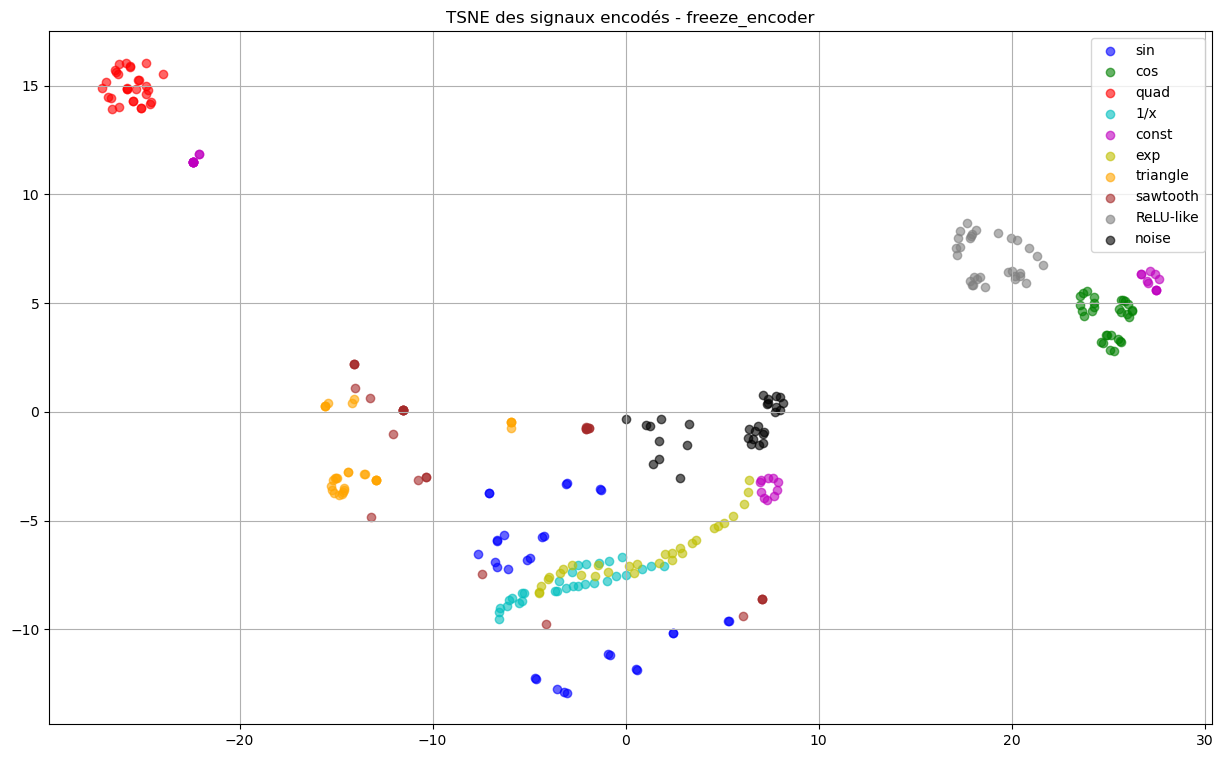

In [ ]:
def generate_and_encode_signal(signal_fn, start_vals, encoder):
    ys = []
    for start in start_vals:
        x = torch.linspace(1 * start, 1 * start + 50, 128)
        y = signal_fn(x)
        y = y.unsqueeze(0).unsqueeze(-1)  # Shape: [1, seq_len, 1]
        with torch.no_grad():
            _, encoded = encoder_freeze(y)
        encoded = encoded.squeeze(0).squeeze(0)
        ys.append(encoded)
    return torch.stack(ys, dim=0)

start_vals = [1, 3, 5, 10, 15, 20, 30, 40, 50, 60]

# Définir les variantes pour chaque type de signal
sin_variants = [
    lambda x: torch.sin(x),
    lambda x: torch.sin(x / 2),
    lambda x: torch.sin(x * 2)
]

cos_variants = [
    lambda x: torch.cos(x / 5) + 10,
    lambda x: torch.cos(x / 3) + 5,
    lambda x: 2 * torch.cos(x / 6) + 7
]

quad_variants = [
    lambda x: -x ** 2,
    lambda x: -(x - 25) ** 2,
    lambda x: -0.5 * x ** 2 + 10
]

inv_variants = [
    lambda x: 1 / (x + 1),               # décale pour éviter div par 0
    lambda x: 2 / (x + 1),
    lambda x: -1 / (x + 1)
]

const_variants = [
    lambda x: torch.ones_like(x) * 3,
    lambda x: torch.ones_like(x) * -2,
    lambda x: torch.ones_like(x) * 0.5
]

exp_variants = [
    lambda x: torch.exp(-x / 10),
    lambda x: torch.exp(-x / 20),
    lambda x: 2 * torch.exp(-x / 15)
]

triangle_variants = [
    lambda x: 2 * torch.abs((x % 10) - 5) - 5,
    lambda x: torch.abs((x % 20) - 10) - 5,
    lambda x: 4 * torch.abs(((x / 2) % 5) - 2.5) - 5
]

sawtooth_variants = [
    lambda x: (x % 10) - 5,
    lambda x: ((x % 20) - 10) / 2,
    lambda x: (x % 5) - 2.5
]

relu_like_variants = [
    lambda x: torch.nn.functional.relu(x - 25),
    lambda x: torch.nn.functional.relu(x - 15) * 0.5,
    lambda x: torch.nn.functional.relu(x - 35) * 2
]

noise_variants = [
    lambda x: torch.rand_like(x),                      # bruit uniforme [0, 1]
    lambda x: torch.randn_like(x),                     # bruit gaussien
    lambda x: torch.randn_like(x) * 0.5 + 1.0          # gaussien centré en 1
]


# Générer les embeddings pour chaque type
sin_ys = torch.cat([generate_and_encode_signal(fn, start_vals, encoder) for fn in sin_variants], dim=0)
cos_ys = torch.cat([generate_and_encode_signal(fn, start_vals, encoder) for fn in cos_variants], dim=0)
quad_ys = torch.cat([generate_and_encode_signal(fn, start_vals, encoder) for fn in quad_variants], dim=0)
inv_ys = torch.cat([generate_and_encode_signal(fn, start_vals, encoder) for fn in inv_variants], dim=0)
const_ys = torch.cat([generate_and_encode_signal(fn, start_vals, encoder) for fn in const_variants], dim=0)
exp_ys = torch.cat([generate_and_encode_signal(fn, start_vals, encoder) for fn in exp_variants], dim=0)
triangle_ys = torch.cat([generate_and_encode_signal(fn, start_vals, encoder) for fn in triangle_variants], dim=0)
saw_ys = torch.cat([generate_and_encode_signal(fn, start_vals, encoder) for fn in sawtooth_variants], dim=0)
relu_ys = torch.cat([generate_and_encode_signal(fn, start_vals, encoder) for fn in relu_like_variants], dim=0)
noise_ys = torch.cat([generate_and_encode_signal(fn, start_vals, encoder) for fn in noise_variants], dim=0)

# Empiler et aplatir
all_signals = torch.cat([
    sin_ys, cos_ys, quad_ys, inv_ys, const_ys,
    exp_ys, triangle_ys, saw_ys, relu_ys, noise_ys
], dim=0)

all_signals = all_signals.flatten(start_dim=1)

# PCA
pca = TSNE(n_components=2)
all_np = all_signals.cpu().numpy()
embeddings_2d = pca.fit_transform(all_np)

# Affichage
N = len(start_vals)
plt.figure(figsize=(15, 9))
labels = [
    "Sinusoidal",
    "Cosine Shifted",
    "Neg Quadratic",
    "Inverse",
    "Constant",
    "Exponential Decay",
    "Triangle Wave",
    "Sawtooth Wave",
    "ReLU-like",
    "Noisy Signal"
]
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'orange', 'brown', 'gray', 'black']

for i, label in enumerate(labels):
    plt.scatter(
        embeddings_2d[i*N*3:(i+1)*N*3, 0],
        embeddings_2d[i*N*3:(i+1)*N*3, 1],
        alpha=0.6, label=label, color=colors[i % len(colors)]
    )

plt.legend()
plt.title("TSNE des signaux encodés - freeze_encoder")
plt.grid(True)
plt.show()


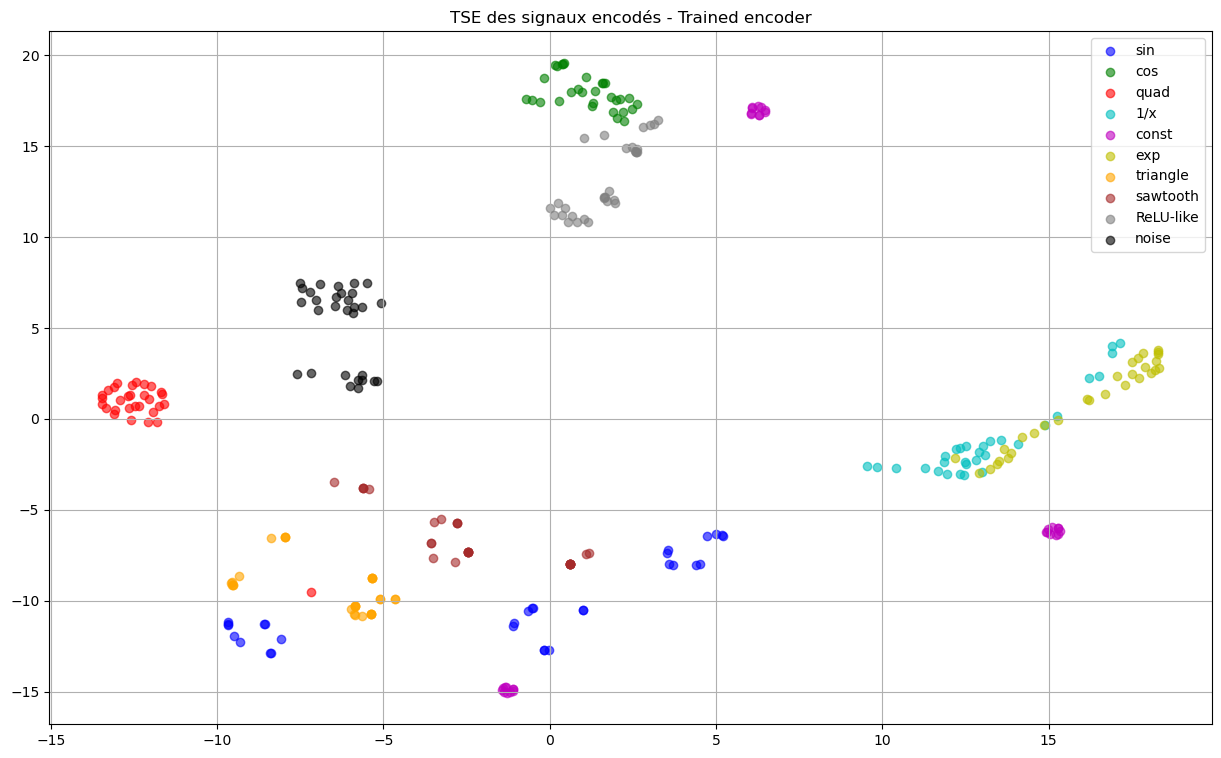

In [ ]:
def generate_and_encode_signal(signal_fn, start_vals, encoder):
    ys = []
    for start in start_vals:
        x = torch.linspace(1 * start, 1 * start + 50, 128)
        y = signal_fn(x)
        y = y.unsqueeze(0).unsqueeze(-1)  # Shape: [1, seq_len, 1]
        with torch.no_grad():
            _, encoded = encoder(y)
        encoded = encoded.squeeze(0).squeeze(0)
        ys.append(encoded)
    return torch.stack(ys, dim=0)

start_vals = [1, 3, 5, 10, 15, 20, 30, 40, 50, 60]

# Définir les variantes pour chaque type de signal
sin_variants = [
    lambda x: torch.sin(x),
    lambda x: torch.sin(x / 2),
    lambda x: torch.sin(x * 2)
]

cos_variants = [
    lambda x: torch.cos(x / 5) + 10,
    lambda x: torch.cos(x / 3) + 5,
    lambda x: 2 * torch.cos(x / 6) + 7
]

quad_variants = [
    lambda x: -x ** 2,
    lambda x: -(x - 25) ** 2,
    lambda x: -0.5 * x ** 2 + 10
]

inv_variants = [
    lambda x: 1 / (x + 1),               # décale pour éviter div par 0
    lambda x: 2 / (x + 1),
    lambda x: -1 / (x + 1)
]

const_variants = [
    lambda x: torch.ones_like(x) * 3,
    lambda x: torch.ones_like(x) * -2,
    lambda x: torch.ones_like(x) * 0.5
]

exp_variants = [
    lambda x: torch.exp(-x / 10),
    lambda x: torch.exp(-x / 20),
    lambda x: 2 * torch.exp(-x / 15)
]

triangle_variants = [
    lambda x: 2 * torch.abs((x % 10) - 5) - 5,
    lambda x: torch.abs((x % 20) - 10) - 5,
    lambda x: 4 * torch.abs(((x / 2) % 5) - 2.5) - 5
]

sawtooth_variants = [
    lambda x: (x % 10) - 5,
    lambda x: ((x % 20) - 10) / 2,
    lambda x: (x % 5) - 2.5
]

relu_like_variants = [
    lambda x: torch.nn.functional.relu(x - 25),
    lambda x: torch.nn.functional.relu(x - 15) * 0.5,
    lambda x: torch.nn.functional.relu(x - 35) * 2
]

noise_variants = [
    lambda x: torch.rand_like(x),                      # bruit uniforme [0, 1]
    lambda x: torch.randn_like(x),                     # bruit gaussien
    lambda x: torch.randn_like(x) * 0.5 + 1.0          # gaussien centré en 1
]


# Générer les embeddings pour chaque type
sin_ys = torch.cat([generate_and_encode_signal(fn, start_vals, encoder) for fn in sin_variants], dim=0)
cos_ys = torch.cat([generate_and_encode_signal(fn, start_vals, encoder) for fn in cos_variants], dim=0)
quad_ys = torch.cat([generate_and_encode_signal(fn, start_vals, encoder) for fn in quad_variants], dim=0)
inv_ys = torch.cat([generate_and_encode_signal(fn, start_vals, encoder) for fn in inv_variants], dim=0)
const_ys = torch.cat([generate_and_encode_signal(fn, start_vals, encoder) for fn in const_variants], dim=0)
exp_ys = torch.cat([generate_and_encode_signal(fn, start_vals, encoder) for fn in exp_variants], dim=0)
triangle_ys = torch.cat([generate_and_encode_signal(fn, start_vals, encoder) for fn in triangle_variants], dim=0)
saw_ys = torch.cat([generate_and_encode_signal(fn, start_vals, encoder) for fn in sawtooth_variants], dim=0)
relu_ys = torch.cat([generate_and_encode_signal(fn, start_vals, encoder) for fn in relu_like_variants], dim=0)
noise_ys = torch.cat([generate_and_encode_signal(fn, start_vals, encoder) for fn in noise_variants], dim=0)

# Empiler et aplatir
all_signals = torch.cat([
    sin_ys, cos_ys, quad_ys, inv_ys, const_ys,
    exp_ys, triangle_ys, saw_ys, relu_ys, noise_ys
], dim=0)

all_signals = all_signals.flatten(start_dim=1)

# PCA
pca = TSNE(n_components=2)
all_np = all_signals.cpu().numpy()
embeddings_2d = pca.fit_transform(all_np)

# Affichage
N = len(start_vals)
plt.figure(figsize=(15, 9))
labels = [
    "Sinusoidal",
    "Cosine Shifted",
    "Neg Quadratic",
    "Inverse",
    "Constant",
    "Exponential Decay",
    "Triangle Wave",
    "Sawtooth Wave",
    "ReLU-like",
    "Noisy Signal"
]
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'orange', 'brown', 'gray', 'black']

for i, label in enumerate(labels):
    plt.scatter(
        embeddings_2d[i*N*3:(i+1)*N*3, 0],
        embeddings_2d[i*N*3:(i+1)*N*3, 1],
        alpha=0.6, label=label, color=colors[i % len(colors)]
    )

plt.legend()
plt.title("TSE des signaux encodés - Trained encoder")
plt.grid(True)
plt.show()


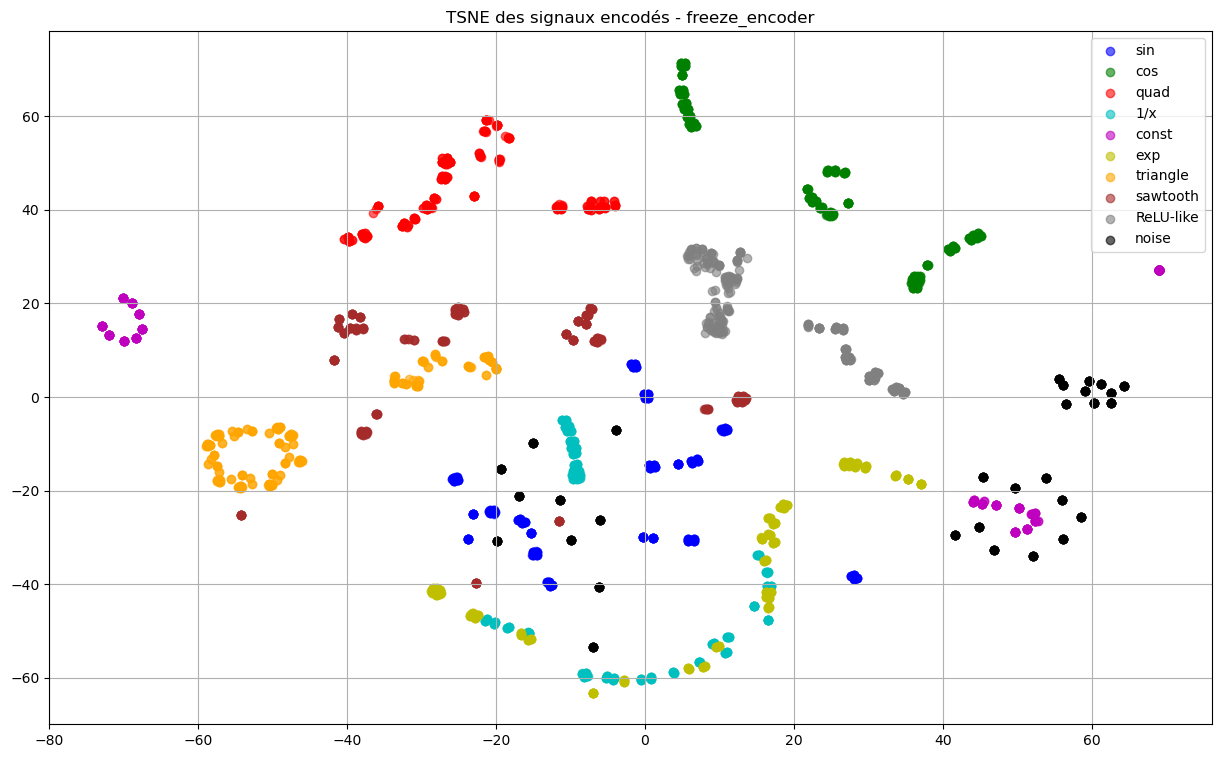

In [ ]:
def generate_and_encode_signal(signal_fn, start_vals, encoder):
    ys = []
    for start in start_vals:
        x = torch.linspace(1 * start, 1 * start + 50, 128)
        y = signal_fn(x)
        y = y.unsqueeze(0).unsqueeze(-1)  # Shape: [1, seq_len, 1]
        with torch.no_grad():
            _, encoded = encoder_freeze(y)
        encoded = encoded.squeeze(0).squeeze(0)
        ys.append(encoded)
    return torch.stack(ys, dim=0)

start_vals = [1, 3, 5, 10, 15, 20, 30, 40, 50, 60]

# Définir les variantes pour chaque type de signal
sin_variants = [
    lambda x: torch.sin(x),
    lambda x: torch.sin(x / 2),
    lambda x: torch.sin(x * 2)
]

cos_variants = [
    lambda x: torch.cos(x / 5) + 10,
    lambda x: torch.cos(x / 3) + 5,
    lambda x: 2 * torch.cos(x / 6) + 7
]

quad_variants = [
    lambda x: -x ** 2,
    lambda x: -(x - 25) ** 2,
    lambda x: -0.5 * x ** 2 + 10
]

inv_variants = [
    lambda x: 1 / (x + 1),               # décale pour éviter div par 0
    lambda x: 2 / (x + 1),
    lambda x: -1 / (x + 1)
]

const_variants = [
    lambda x: torch.ones_like(x) * 3,
    lambda x: torch.ones_like(x) * -2,
    lambda x: torch.ones_like(x) * 0.5
]

exp_variants = [
    lambda x: torch.exp(-x / 10),
    lambda x: torch.exp(-x / 20),
    lambda x: 2 * torch.exp(-x / 15)
]

triangle_variants = [
    lambda x: 2 * torch.abs((x % 10) - 5) - 5,
    lambda x: torch.abs((x % 20) - 10) - 5,
    lambda x: 4 * torch.abs(((x / 2) % 5) - 2.5) - 5
]

sawtooth_variants = [
    lambda x: (x % 10) - 5,
    lambda x: ((x % 20) - 10) / 2,
    lambda x: (x % 5) - 2.5
]

relu_like_variants = [
    lambda x: torch.nn.functional.relu(x - 25),
    lambda x: torch.nn.functional.relu(x - 15) * 0.5,
    lambda x: torch.nn.functional.relu(x - 35) * 2
]

noise_variants = [
    lambda x: torch.rand_like(x),                      # bruit uniforme [0, 1]
    lambda x: torch.randn_like(x),                     # bruit gaussien
    lambda x: torch.randn_like(x) * 0.5 + 1.0          # gaussien centré en 1
]


# Générer les embeddings pour chaque type
sin_ys = torch.cat([generate_and_encode_signal(fn, start_vals, encoder) for fn in sin_variants], dim=0)
cos_ys = torch.cat([generate_and_encode_signal(fn, start_vals, encoder) for fn in cos_variants], dim=0)
quad_ys = torch.cat([generate_and_encode_signal(fn, start_vals, encoder) for fn in quad_variants], dim=0)
inv_ys = torch.cat([generate_and_encode_signal(fn, start_vals, encoder) for fn in inv_variants], dim=0)
const_ys = torch.cat([generate_and_encode_signal(fn, start_vals, encoder) for fn in const_variants], dim=0)
exp_ys = torch.cat([generate_and_encode_signal(fn, start_vals, encoder) for fn in exp_variants], dim=0)
triangle_ys = torch.cat([generate_and_encode_signal(fn, start_vals, encoder) for fn in triangle_variants], dim=0)
saw_ys = torch.cat([generate_and_encode_signal(fn, start_vals, encoder) for fn in sawtooth_variants], dim=0)
relu_ys = torch.cat([generate_and_encode_signal(fn, start_vals, encoder) for fn in relu_like_variants], dim=0)
noise_ys = torch.cat([generate_and_encode_signal(fn, start_vals, encoder) for fn in noise_variants], dim=0)

# Empiler et aplatir
all_signals = torch.cat([
    sin_ys, cos_ys, quad_ys, inv_ys, const_ys,
    exp_ys, triangle_ys, saw_ys, relu_ys, noise_ys
], dim=0)

all_signals = all_signals.view(all_signals.size(0)*all_signals.size(1), all_signals.size(2))

# PCA
pca = TSNE(n_components=2)
all_np = all_signals.cpu().numpy()
embeddings_2d = pca.fit_transform(all_np)

# Affichage
N = len(start_vals)
plt.figure(figsize=(15, 9))
labels = [
    "Sinusoidal",
    "Cosine Shifted",
    "Neg Quadratic",
    "Inverse",
    "Constant",
    "Exponential Decay",
    "Triangle Wave",
    "Sawtooth Wave",
    "ReLU-like",
    "Noisy Signal"
]
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'orange', 'brown', 'gray', 'black']

for i, label in enumerate(labels):
    plt.scatter(
        embeddings_2d[i*N*3*8:(i+1)*N*3*8, 0],
        embeddings_2d[i*N*3*8:(i+1)*N*3*8, 1],
        alpha=0.6, label=label, color=colors[i % len(colors)]
    )

plt.legend()
plt.title("TSNE des signaux encodés - freeze_encoder")
plt.grid(True)
plt.show()


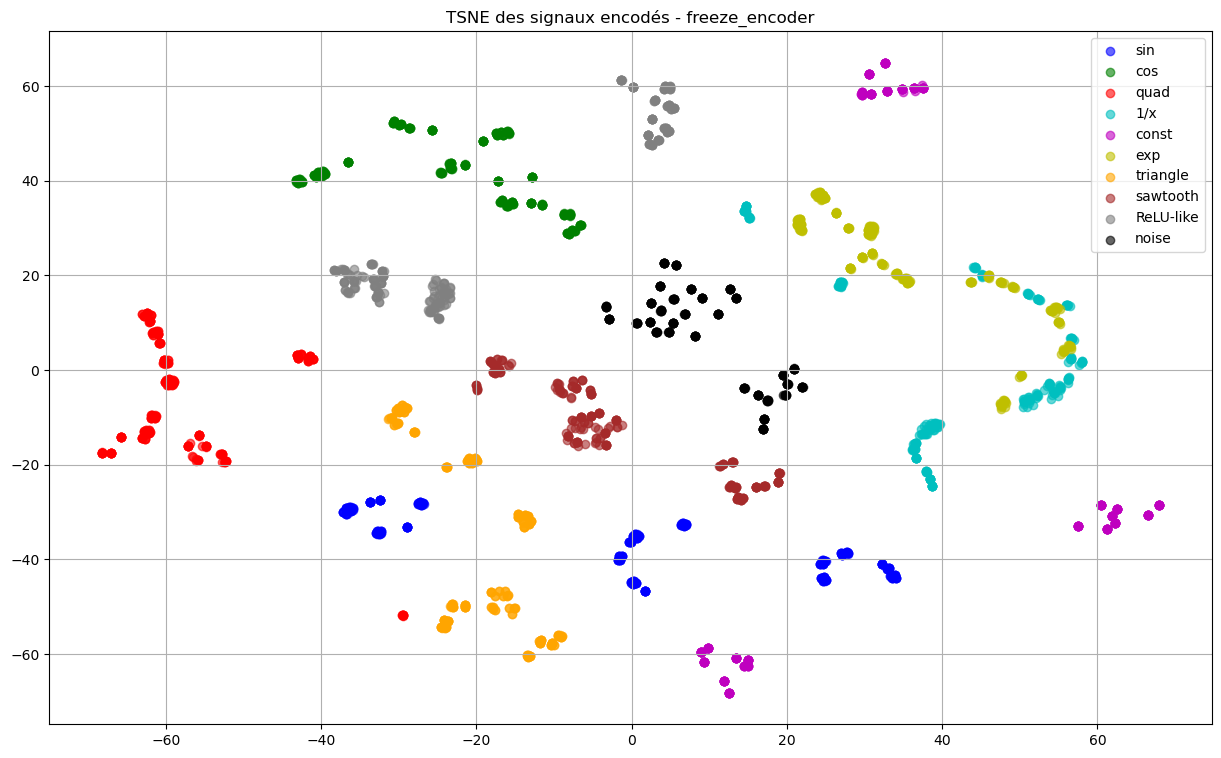

In [ ]:
def generate_and_encode_signal(signal_fn, start_vals, encoder):
    ys = []
    for start in start_vals:
        x = torch.linspace(1 * start, 1 * start + 50, 128)
        y = signal_fn(x)
        y = y.unsqueeze(0).unsqueeze(-1)  # Shape: [1, seq_len, 1]
        with torch.no_grad():
            _, encoded = encoder(y)
        encoded = encoded.squeeze(0).squeeze(0)
        ys.append(encoded)
    return torch.stack(ys, dim=0)

start_vals = [1, 3, 5, 10, 15, 20, 30, 40, 50, 60]

# Définir les variantes pour chaque type de signal
sin_variants = [
    lambda x: torch.sin(x),
    lambda x: torch.sin(x / 2),
    lambda x: torch.sin(x * 2)
]

cos_variants = [
    lambda x: torch.cos(x / 5) + 10,
    lambda x: torch.cos(x / 3) + 5,
    lambda x: 2 * torch.cos(x / 6) + 7
]

quad_variants = [
    lambda x: -x ** 2,
    lambda x: -(x - 25) ** 2,
    lambda x: -0.5 * x ** 2 + 10
]

inv_variants = [
    lambda x: 1 / (x + 1),               # décale pour éviter div par 0
    lambda x: 2 / (x + 1),
    lambda x: -1 / (x + 1)
]

const_variants = [
    lambda x: torch.ones_like(x) * 3,
    lambda x: torch.ones_like(x) * -2,
    lambda x: torch.ones_like(x) * 0.5
]

exp_variants = [
    lambda x: torch.exp(-x / 10),
    lambda x: torch.exp(-x / 20),
    lambda x: 2 * torch.exp(-x / 15)
]

triangle_variants = [
    lambda x: 2 * torch.abs((x % 10) - 5) - 5,
    lambda x: torch.abs((x % 20) - 10) - 5,
    lambda x: 4 * torch.abs(((x / 2) % 5) - 2.5) - 5
]

sawtooth_variants = [
    lambda x: (x % 10) - 5,
    lambda x: ((x % 20) - 10) / 2,
    lambda x: (x % 5) - 2.5
]

relu_like_variants = [
    lambda x: torch.nn.functional.relu(x - 25),
    lambda x: torch.nn.functional.relu(x - 15) * 0.5,
    lambda x: torch.nn.functional.relu(x - 35) * 2
]

noise_variants = [
    lambda x: torch.rand_like(x),                      # bruit uniforme [0, 1]
    lambda x: torch.randn_like(x),                     # bruit gaussien
    lambda x: torch.randn_like(x) * 0.5 + 1.0          # gaussien centré en 1
]


# Générer les embeddings pour chaque type
sin_ys = torch.cat([generate_and_encode_signal(fn, start_vals, encoder) for fn in sin_variants], dim=0)
cos_ys = torch.cat([generate_and_encode_signal(fn, start_vals, encoder) for fn in cos_variants], dim=0)
quad_ys = torch.cat([generate_and_encode_signal(fn, start_vals, encoder) for fn in quad_variants], dim=0)
inv_ys = torch.cat([generate_and_encode_signal(fn, start_vals, encoder) for fn in inv_variants], dim=0)
const_ys = torch.cat([generate_and_encode_signal(fn, start_vals, encoder) for fn in const_variants], dim=0)
exp_ys = torch.cat([generate_and_encode_signal(fn, start_vals, encoder) for fn in exp_variants], dim=0)
triangle_ys = torch.cat([generate_and_encode_signal(fn, start_vals, encoder) for fn in triangle_variants], dim=0)
saw_ys = torch.cat([generate_and_encode_signal(fn, start_vals, encoder) for fn in sawtooth_variants], dim=0)
relu_ys = torch.cat([generate_and_encode_signal(fn, start_vals, encoder) for fn in relu_like_variants], dim=0)
noise_ys = torch.cat([generate_and_encode_signal(fn, start_vals, encoder) for fn in noise_variants], dim=0)

# Empiler et aplatir
all_signals = torch.cat([
    sin_ys, cos_ys, quad_ys, inv_ys, const_ys,
    exp_ys, triangle_ys, saw_ys, relu_ys, noise_ys
], dim=0)

all_signals = all_signals.view(all_signals.size(0)*all_signals.size(1), all_signals.size(2))

# PCA
pca = TSNE(n_components=2)
all_np = all_signals.cpu().numpy()
embeddings_2d = pca.fit_transform(all_np)

# Affichage
N = len(start_vals)
plt.figure(figsize=(15, 9))
labels = [
    "Sinusoidal",
    "Cosine Shifted",
    "Neg Quadratic",
    "Inverse",
    "Constant",
    "Exponential Decay",
    "Triangle Wave",
    "Sawtooth Wave",
    "ReLU-like",
    "Noisy Signal"
]
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'orange', 'brown', 'gray', 'black']

for i, label in enumerate(labels):
    plt.scatter(
        embeddings_2d[i*N*3*8:(i+1)*N*3*8, 0],
        embeddings_2d[i*N*3*8:(i+1)*N*3*8, 1],
        alpha=0.6, label=label, color=colors[i % len(colors)]
    )

plt.legend()
plt.title("TSNE des signaux encodés - freeze_encoder")
plt.grid(True)
plt.show()


In [ ]:
x = torch.linspace(1, 50, 100)

sin_variants = torch.sin(x / 2),
cos_variants = torch.cos(x / 3) + 5,
quad_variants = -(x - 25) ** 2,
inv_variants = 2 / (x + 1),
const_variants = torch.ones_like(x) * -2,
exp_variants = torch.exp(-x / 20),
triangle_variants = torch.abs((x % 20) - 10) - 5,
sawtooth_variants = lambda x: ((x % 20) - 10) / 2,
relu_like_variants = torch.nn.functional.relu(x - 15) * 0.5,
noise_variants = torch.randn_like(x) * 0.5 + 1.0

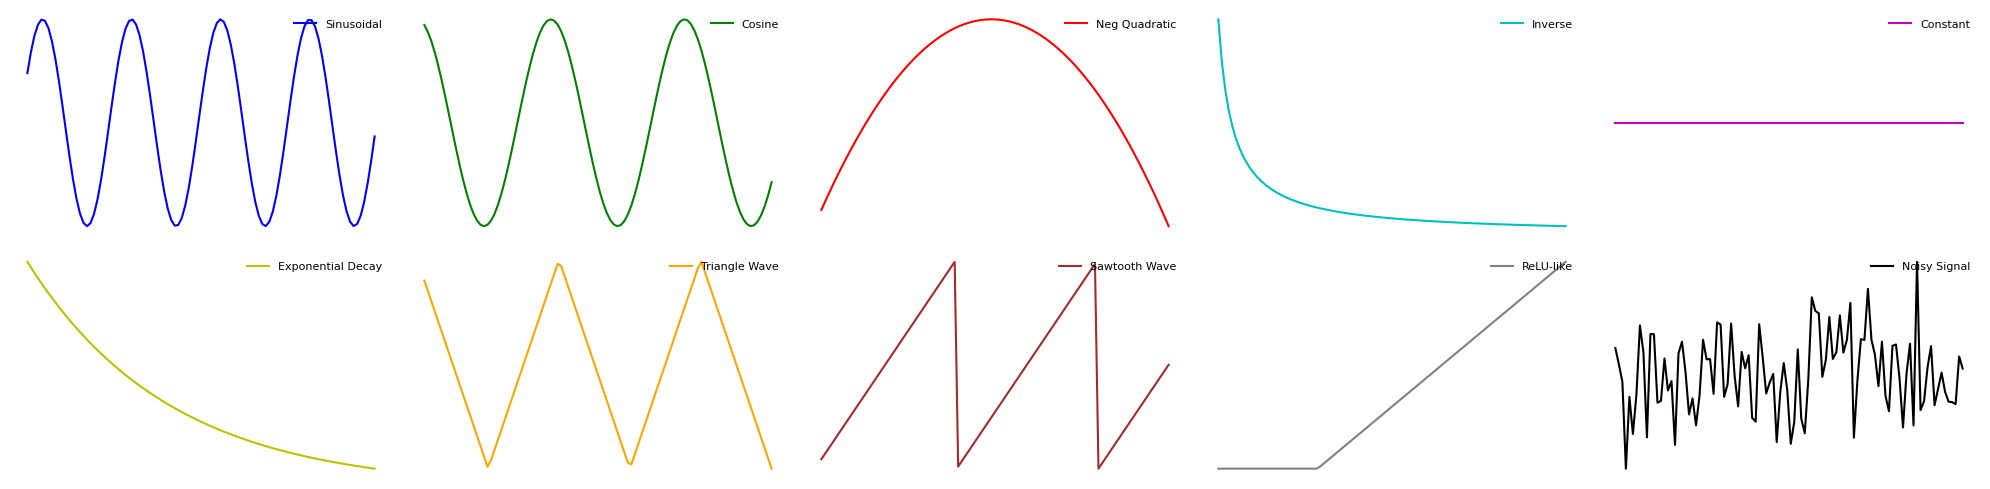

In [ ]:
import torch
import matplotlib.pyplot as plt

# Data
x = torch.linspace(1, 50, 100)
signals = [
    torch.sin(x / 2),
    torch.cos(x / 3) + 5,
    -(x - 25) ** 2,
    2 / (x + 1),
    torch.ones_like(x) * -2,
    torch.exp(-x / 20),
    torch.abs((x % 20) - 10) - 5,
    ((x % 20) - 10) / 2,
    torch.nn.functional.relu(x - 15) * 0.5,
    torch.randn_like(x) * 0.5 + 1.0
]
labels = [
    "Sinusoidal",
    "Cosine",
    "Neg Quadratic",
    "Inverse",
    "Constant",
    "Exponential Decay",
    "Triangle Wave",
    "Sawtooth Wave",
    "ReLU-like",
    "Noisy Signal"
]
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'orange', 'brown', 'gray', 'black']

# Two-column layout
fig, axes = plt.subplots(2, 5, figsize=(20, 5), sharex=True)

axes = axes.flatten()  # flatten 2D array of axes for easy indexing

for i, (signal, ax) in enumerate(zip(signals, axes)):
    ax.plot(x, signal, color=colors[i], label=labels[i])
    ax.legend(loc="upper right", frameon=False, fontsize=8)
    ax.axis('off')

# Hide any extra axes if needed
for j in range(len(signals), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.savefig("signals_plot.png", dpi=300)
plt.show()